In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from tensorboardX import SummaryWriter
import tqdm
import os
import uuid
import matplotlib.pyplot as plt
%matplotlib inline
import os

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

unique_id = str(uuid.uuid4())

def weights_initialize(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
        module.bias.data.fill_(0.01)
        
class _TransModel(nn.Module):
    """ Model for DQN """

    def __init__(self, input_len, output_len):
        super(_TransModel, self).__init__()
        
        self.fc1 = nn.Sequential(
            torch.nn.Linear(input_len, 1024),
#             torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(0.5),
            nn.ReLU()
        )
        self.fc1.apply(weights_initialize)
        
        self.fc2 = nn.Sequential(
            torch.nn.Linear(1024, 512),
#             torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.5),
            nn.ReLU()
        )
        self.fc2.apply(weights_initialize)
        
        self.fc3 = nn.Sequential(
            torch.nn.Linear(512, 256),
#             torch.nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc3.apply(weights_initialize)
        
        self.output_layer = nn.Sequential(
            torch.nn.Linear(256, output_len)
        )
        self.output_layer.apply(weights_initialize)
        
        
    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.output_layer(x)

    
class TransModel():
    def __init__(self, input_len, ouput_len, learning_rate = 0.00005):
        self.model = _TransModel(input_len, ouput_len)
        
        if use_cuda:
            print("Using GPU")
            self.model = self.model.cuda()
        else:
            print("Using CPU")
        self.steps = 0
        # self.model = nn.DataParallel(self.model)
        self.optimizer = Adam(self.model.parameters(), lr = learning_rate)
#         self.loss_fn = nn.MSELoss(reduction='mean')
        self.loss_fn = nn.SmoothL1Loss()
        
        self.steps = 0
        
    def predict(self, input, steps, learning):
        output = self.model(input).squeeze(1)
        #reward, next_state = output[0], output[1:]

        return output

    def predict_batch(self, input):
        output = self.model(input)
        #reward, next_state = output[:, 0], output[:, 1:]
        return output

    def fit(self, state, target_state):
        loss = self.loss_fn(state, target_state)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        return loss
    
    def save(self):
        cwd = os.getcwd()
        path = cwd + '/models'
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
        file_path = path + '/UNITS_' + unique_id + '.pt'
        torch.save(self.model.state_dict(), file_path)

In [2]:
def dot_plot(x, y, fig, style = 'o'):
    legend = [
                "Match line",
                "Player 1 Top Marine",
                "Player 1 Top Baneling",
                "Player 1 Top Immortal",
                "Player 1 Bottom Marine",
                "Player 1 Bottom Baneling",
                "Player 1 Bottom Immortal",
                "Player 2 Top Marine",
                "Player 2 Top Baneling",
                "Player 2 Top Immortal",
                "Player 2 Bottom Marine",
                "Player 2 Bottom Baneling",
                "Player 2 Bottom Immortal",
             ]
    fig=plt.figure(figsize=(15, 15), dpi= 160, facecolor='w', edgecolor='k')
    
    ax = plt.subplot(111)
    ax.set_ylim([-5,50])
    ax.set_xlim([-5,50])
    ax.plot(list(range(-5,50)),list(range(-5,50)), "b--", alpha=0.1)
    for i in range(len(legend) - 1):
#         plt.plot(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(), style, s = 0.1)
        ax.scatter(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(),s = 0.5)
        
    plt.title('Ground Truth - Predict of Units')
    plt.legend(legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predict")
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1)

    return plt

In [3]:
#data = torch.load('test_random_vs_random_2l.pt')
data = torch.load('all_experiences.pt')

np.set_printoptions(suppress=True)
l = len(data)
# norm_vector = np.array([700, # p1 minerals
#                         50, 40, 10, 50, 40, 10, 3, # p1 top and bottom lane buildings
#                         50, 40, 10, 50, 40, 10, 3, # p2 top and bottom lane buildings
#                         50, 40, 10, 50, 40, 10, # p1 top and bottom lane units
#                         50, 40, 10, 50, 40, 10, # p1 top and bottom lane units
#                         2000, 2000, 2000, 2000, 40])

norm_vector = np.array([1500, # p1 minerals
                        30, 30, 10, 30, 30, 10, 3, # p1 top and bottom lane buildings
                        30, 30, 10, 30, 30, 10, 3, # p2 top and bottom lane buildings
                        30, 30, 10, 30, 30, 10, # p1 top and bottom lane units
                        30, 30, 10, 30, 30, 10, # p1 top and bottom lane units
                        2000, 2000, 2000, 2000, 40])

for i in range(0, len(data)):
#     data[i][1] = data[i][1][15:27] - data[i][0][15:27]
    
    data[i][0] = data[i][0] / norm_vector # normalize input
#     data[i][1] = data[i][1][0:32] / norm_vector # normalize ground truth
#     data[i][0] = data[i][0][1:27]
#     data[i][1] = data[i][1][0:32]

    data[i][1] = data[i][1][15:27] # set output to units in top and bottom lanes 
    
print(data[100][0])
print(data[100][1])

np.random.shuffle(data)

train_data = np.array(data[: int(np.floor(l * 0.9))])
test_data = np.array(data[int(np.floor(l * 0.9)) : ])
# print(train_data.shape, test_data.shape)
# norm_vector = np.max(np.array(train_data[:][0]), axis = 0)
# print(norm_vector)

batch_size = 512
summary_test = SummaryWriter(log_dir = 'units-on-field-transition-model-report/')

[0.1        0.03333333 0.         0.         0.1        0.
 0.         0.         0.         0.         0.         0.
 0.03333333 0.         0.         0.         0.         0.
 0.1        0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.075     ]
[1. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
baselineCurrent = np.stack(test_data[:, 0])
baselineNextUnits = np.stack(test_data[:, 1])
baselineCurrentUnits = baselineCurrent[:, 15:27]

print(baselineCurrentUnits[0])
print(baselineNextUnits[0])

mse_baseline = ((baselineCurrentUnits - baselineNextUnits)**2).mean(axis=None)
print(mse_baseline)

[0.13333333 0.         0.         0.13333333 0.         0.
 0.         0.         0.         0.         0.         0.        ]
[6. 1. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]
18.57781782407407


In [5]:
trans_model = TransModel(len(data[0][0]), len(data[0][1]))

Using GPU


In [6]:


def evaluation(model, data, epoch):
    state_action = torch.from_numpy(np.stack(data[:, 0])).type(FloatTensor)
    next_state_reward = torch.from_numpy(np.stack(data[:, 1])).type(FloatTensor)
    
    model.model.eval()
    criterion = nn.MSELoss(reduction='mean')
    outputs = model.predict_batch(state_action)
    mse = criterion(outputs, next_state_reward)
    mse_p1 = criterion(outputs, next_state_reward)
    mse_p2 = criterion(outputs, next_state_reward)
    
    
    accuracy = torch.sum( torch.sum( torch.eq( outputs.round(), next_state_reward ) )).item()
    accuracy = accuracy / (outputs.size()[1] * outputs.size()[0])
    if epoch % 1000 == 0:
        print(accuracy)
        p = dot_plot(next_state_reward, outputs, epoch)
        p.show()
    model.model.train()
    
    summary_test.add_scalar("MSE", float(mse.item()), epoch)
    summary_test.add_scalars("MSE",{'Player 1 Unit MSE': float(mse_p1.item())}, epoch)
    summary_test.add_scalars("MSE",{'Player 2 Unit MSE': float(mse_p2.item())}, epoch)
    summary_test.add_scalars("MSE",{'Baseline Unit MSE': float(mse_baseline)}, epoch)

    #summary_test.add_scalar(tag="Accuracy (Correct / Total)",
    #                        scalar_value=float(accuracy),
    #                        global_step=epoch)
    
    f = open("units-on-field-transition-model-report/test_loss.txt", "a+")
    f.write("loss:" + str(mse.item()) + ", ")
    f.write("acc:" + str(accuracy) + "\n")
    if epoch % 1000 == 0:
        f.write("output:" + str(outputs[0:2]) + "\n")
        f.write("ground true:" + str(next_state_reward[0:2]) + "\n")
    f.close()
    return mse.item()

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([14400, 32]) torch.Size([14400, 12])
0.5836979166666667


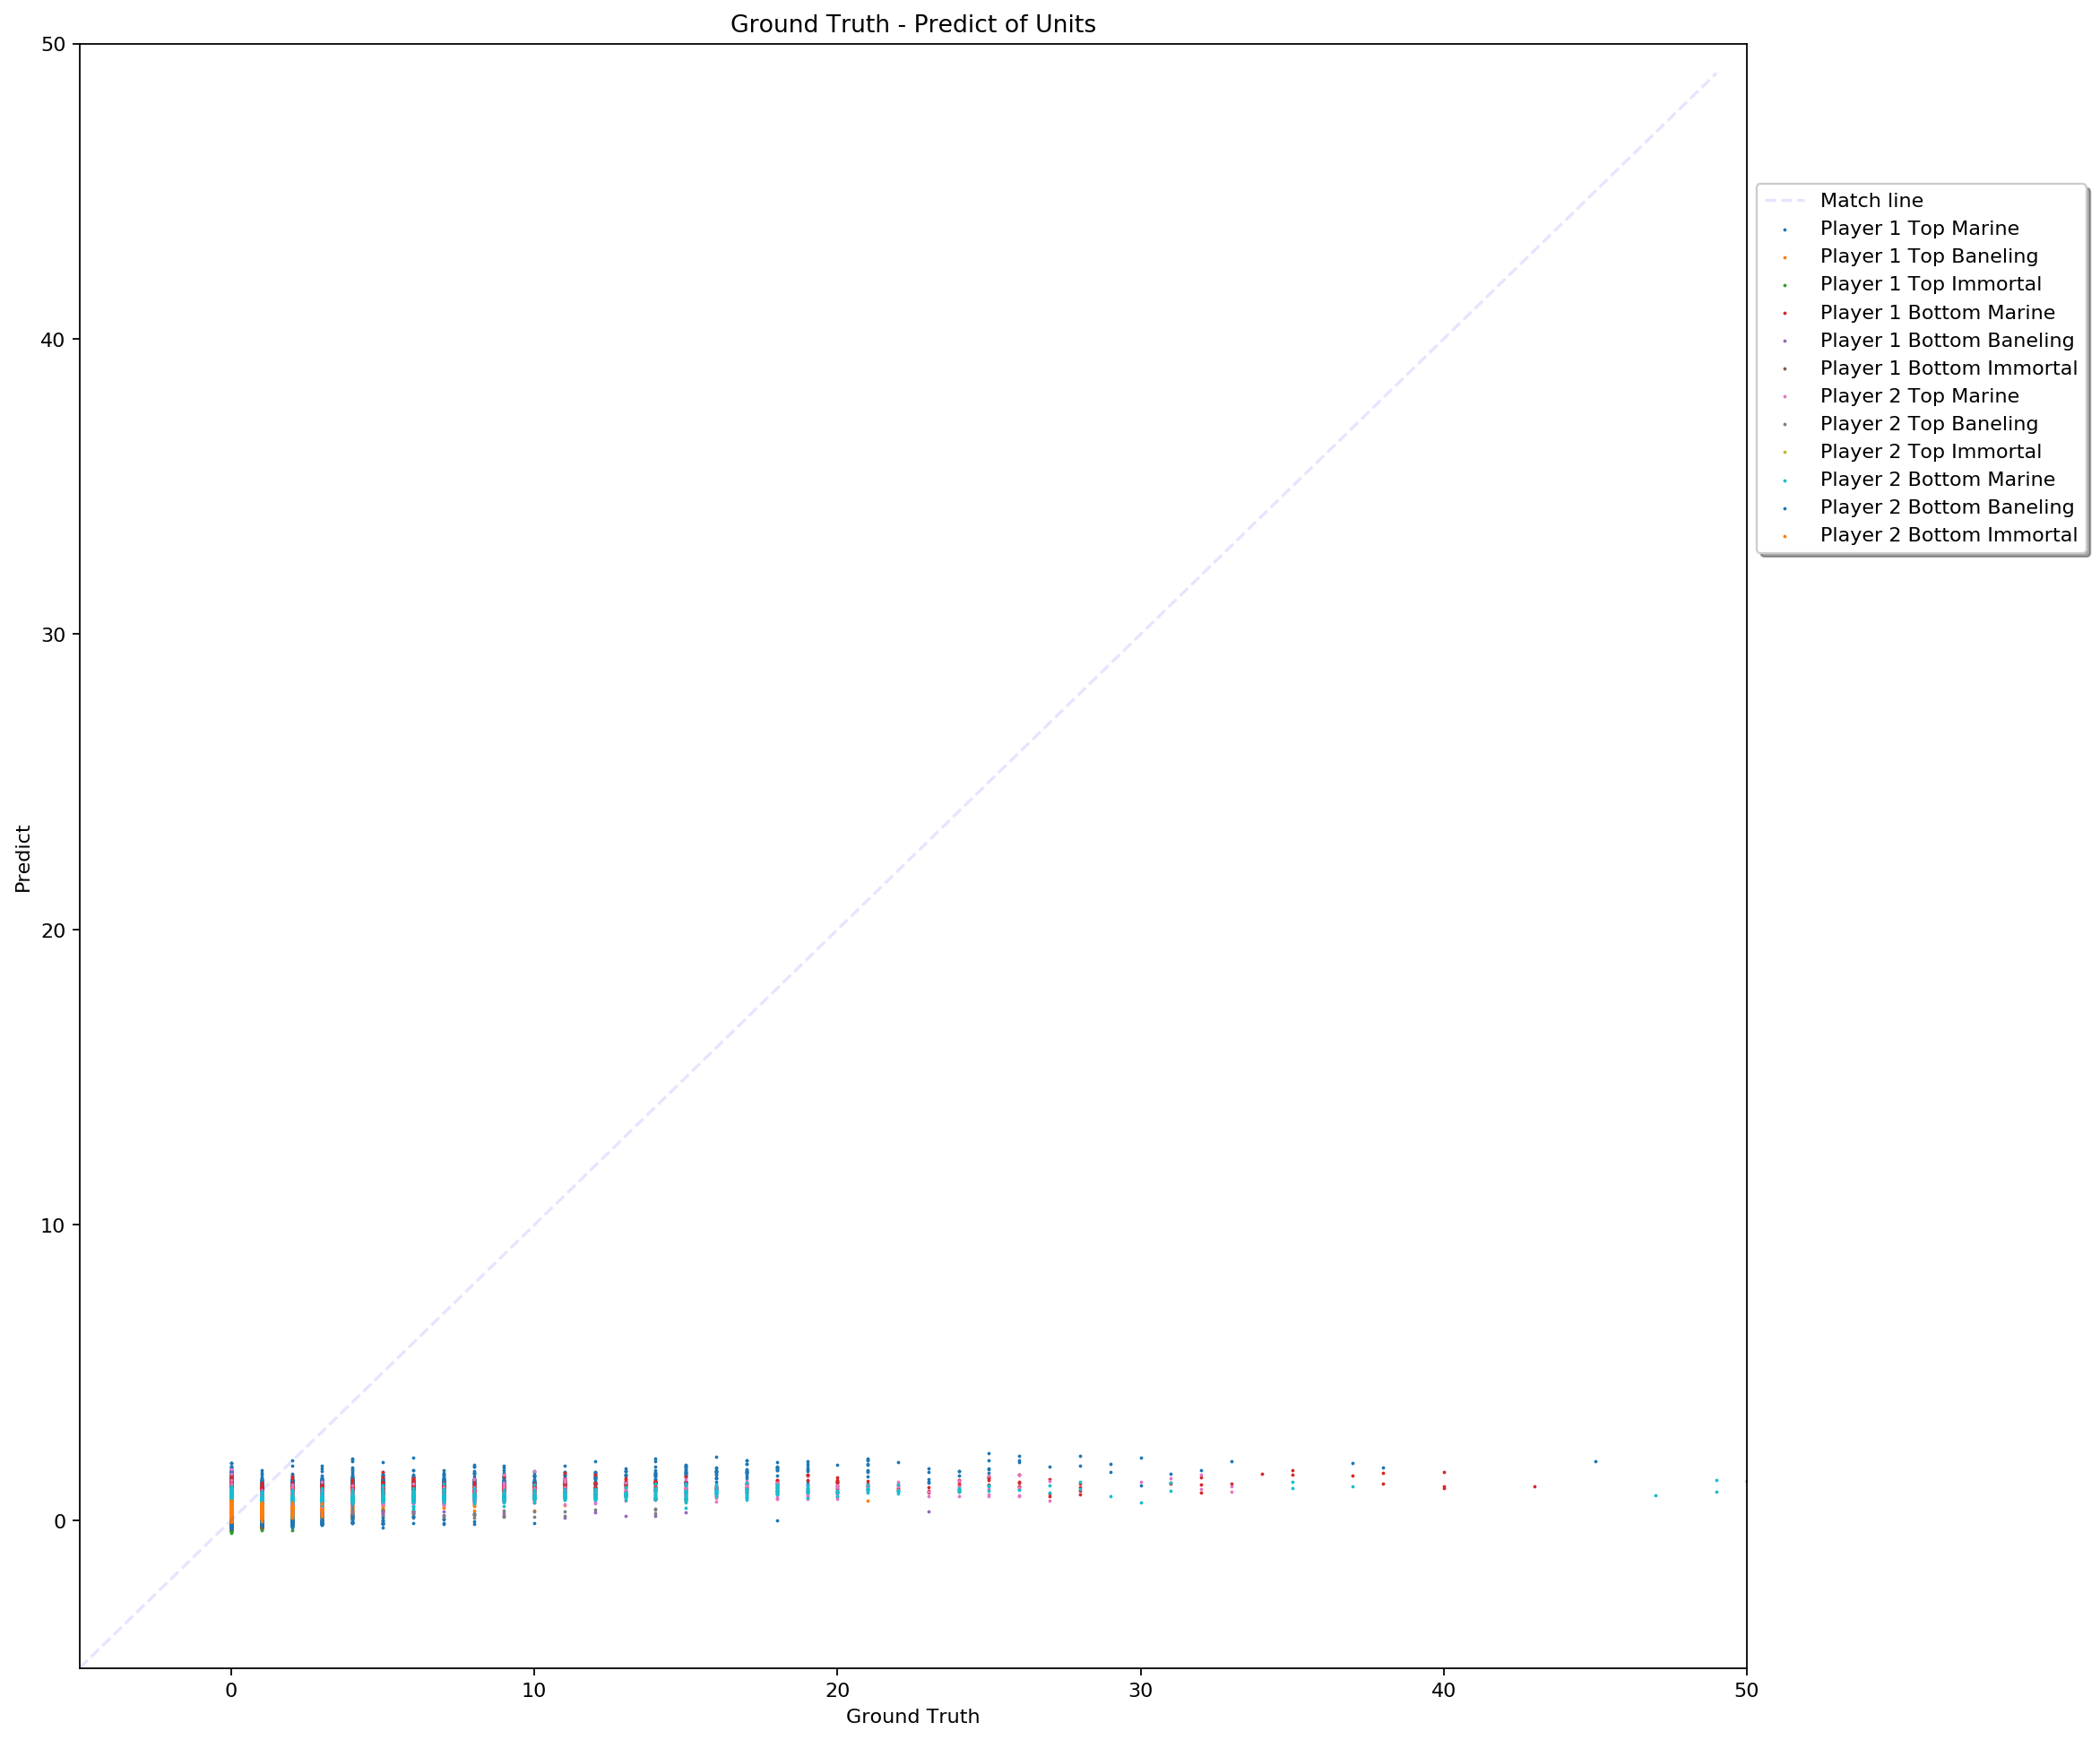

 10%|▉         | 999/10000 [01:03<08:45, 17.13it/s]

0.8207291666666666


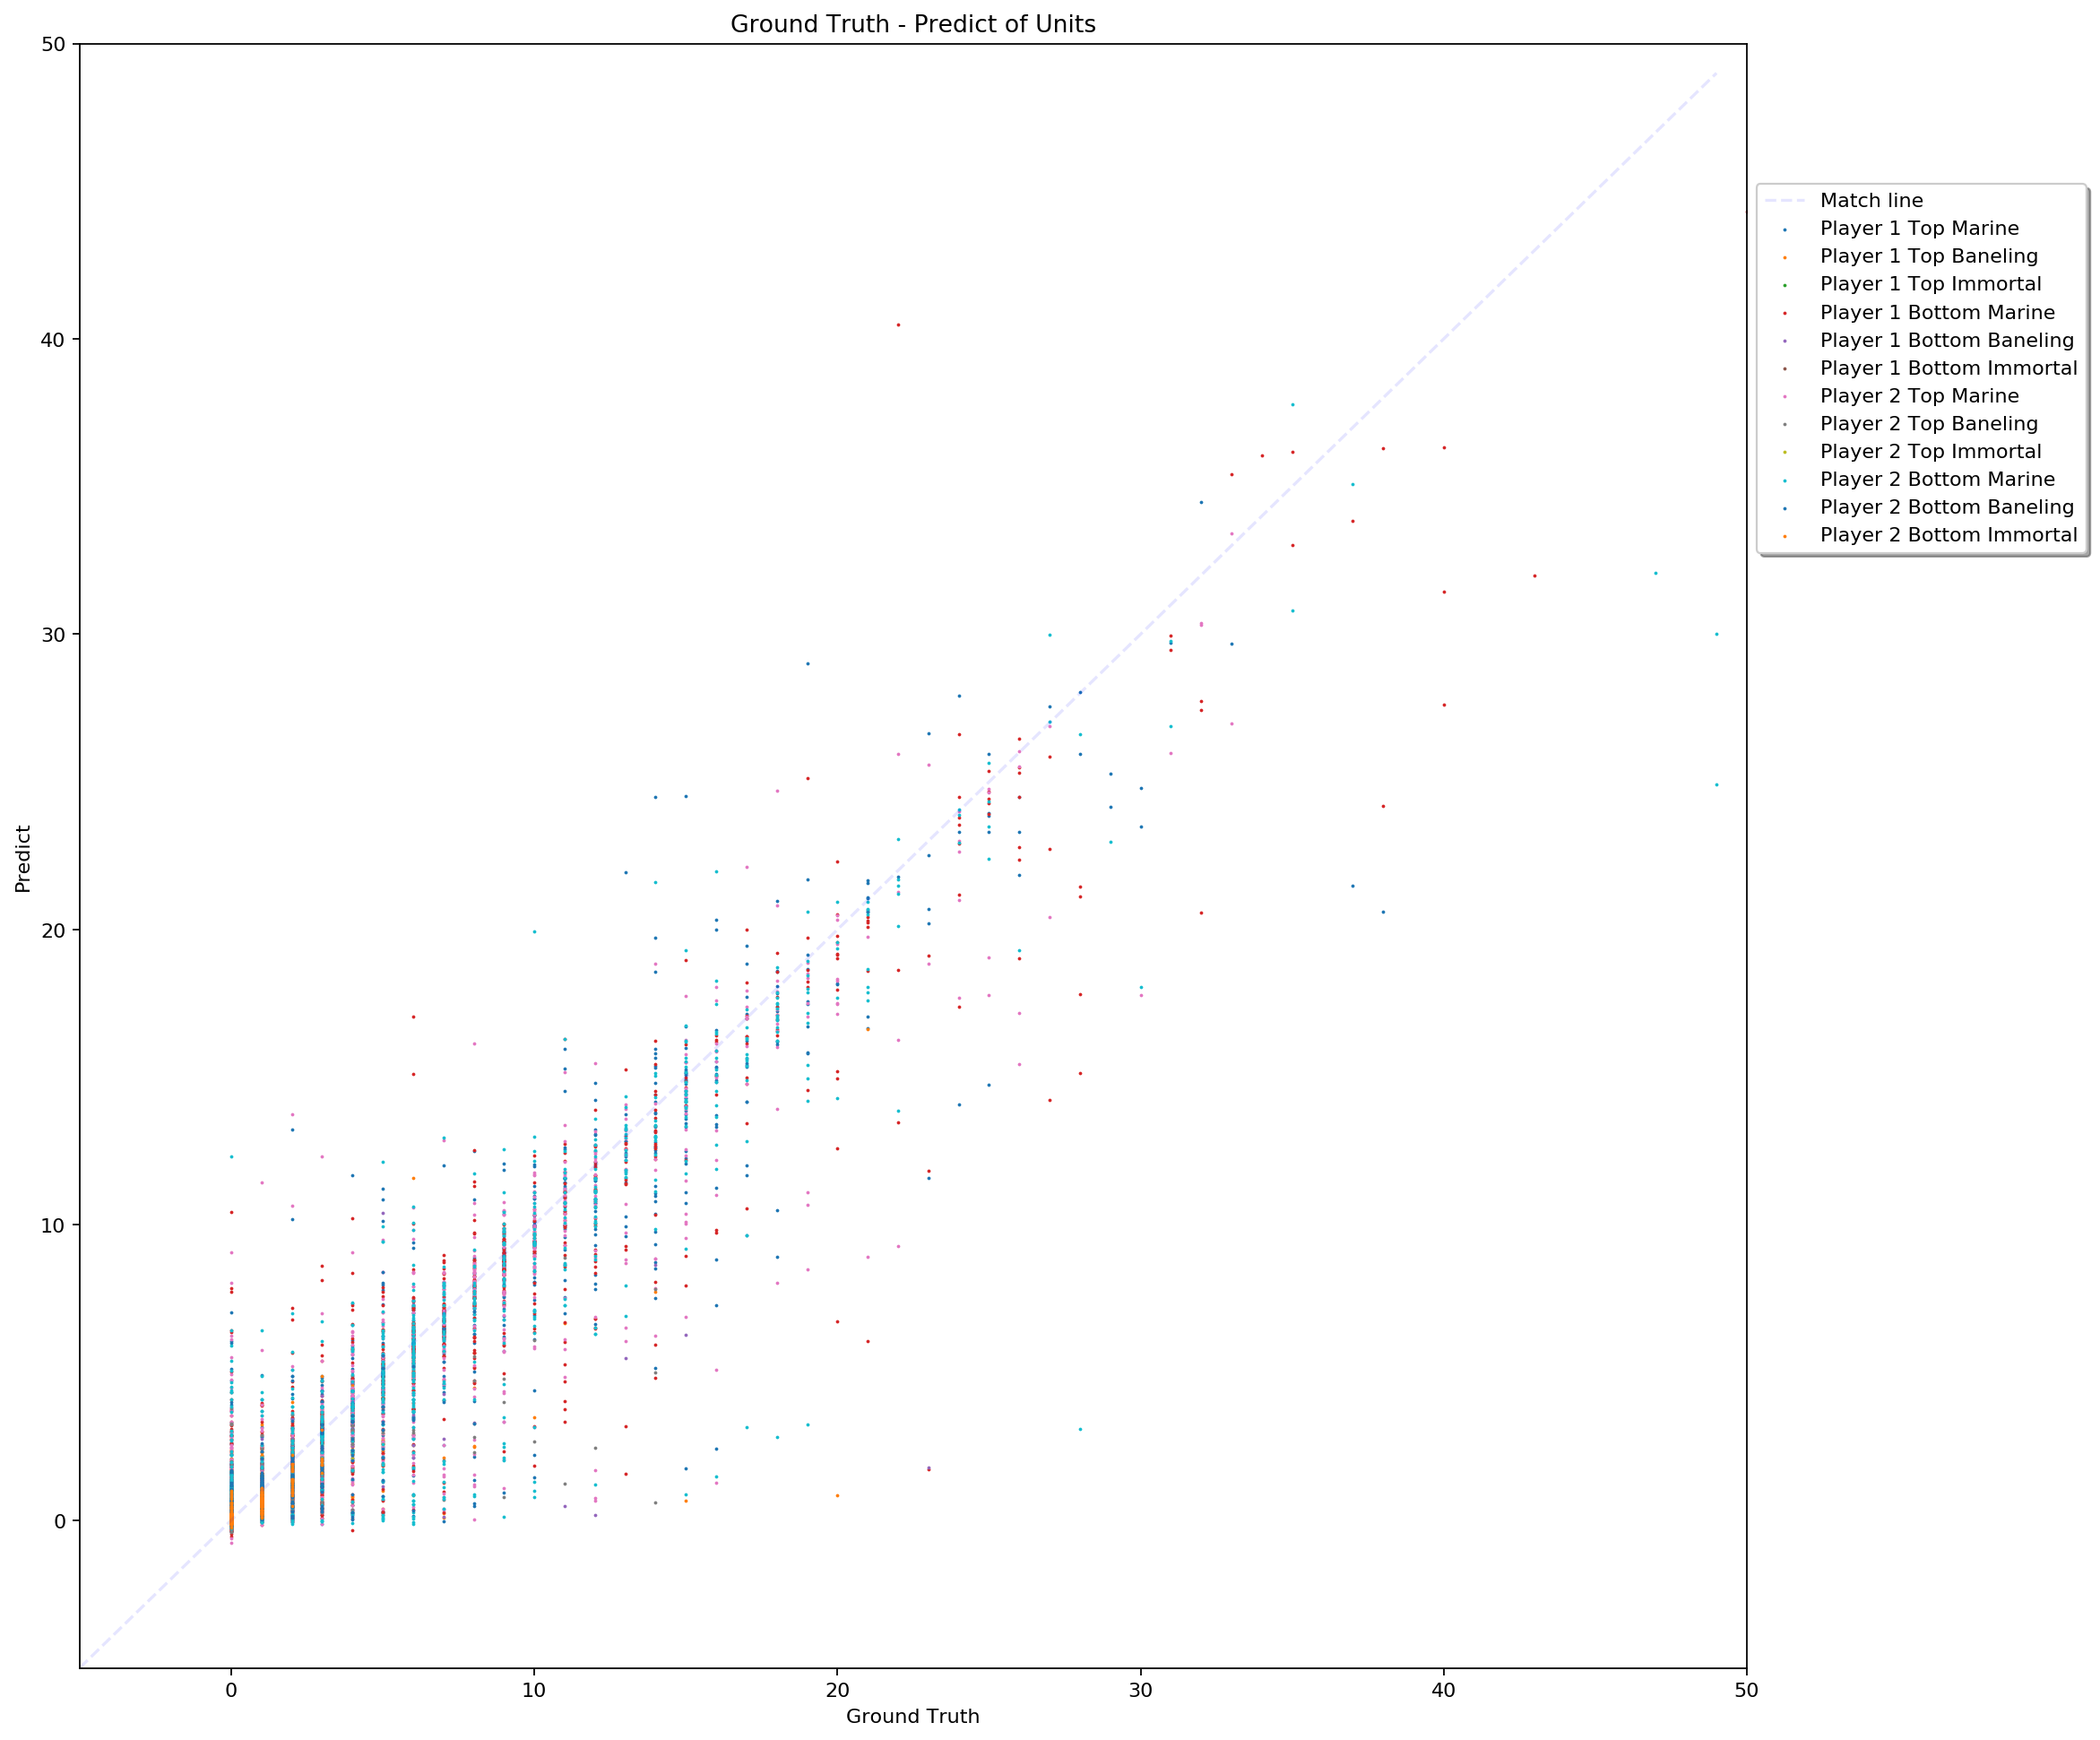

 20%|█▉        | 1999/10000 [02:27<11:21, 11.75it/s]

0.8304166666666667


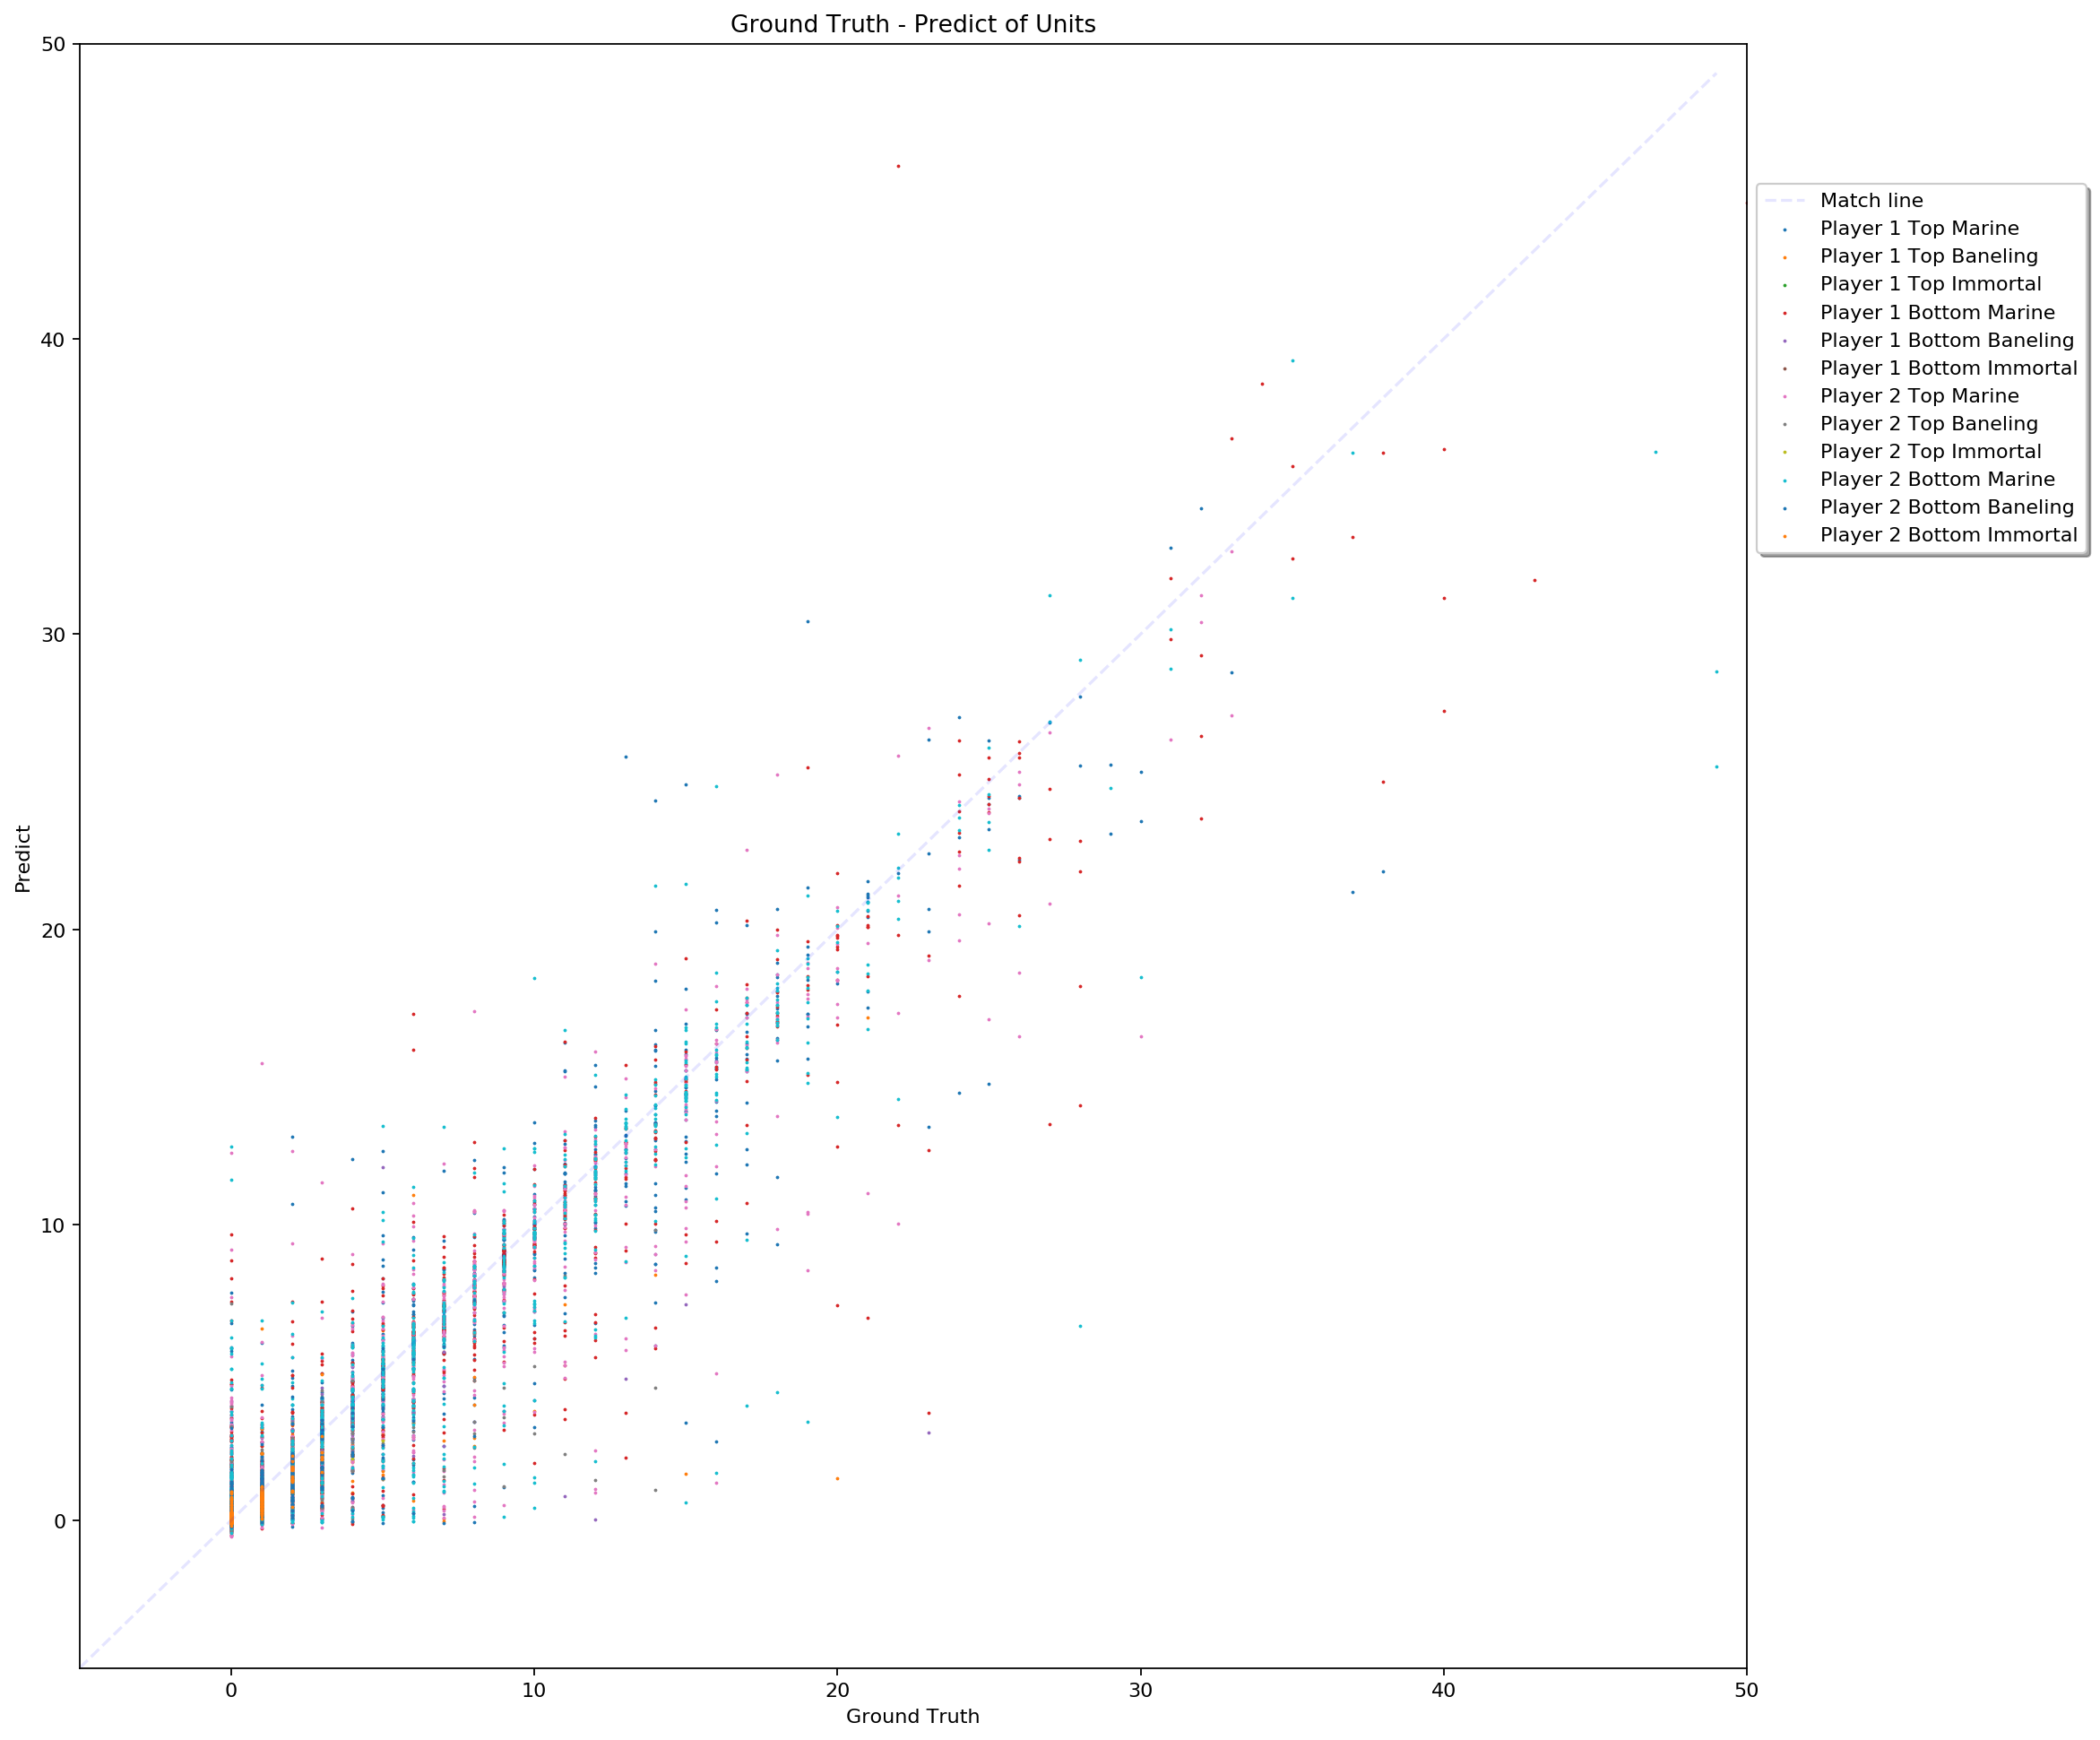

 30%|██▉       | 2999/10000 [03:53<10:00, 11.65it/s]

0.8330729166666667


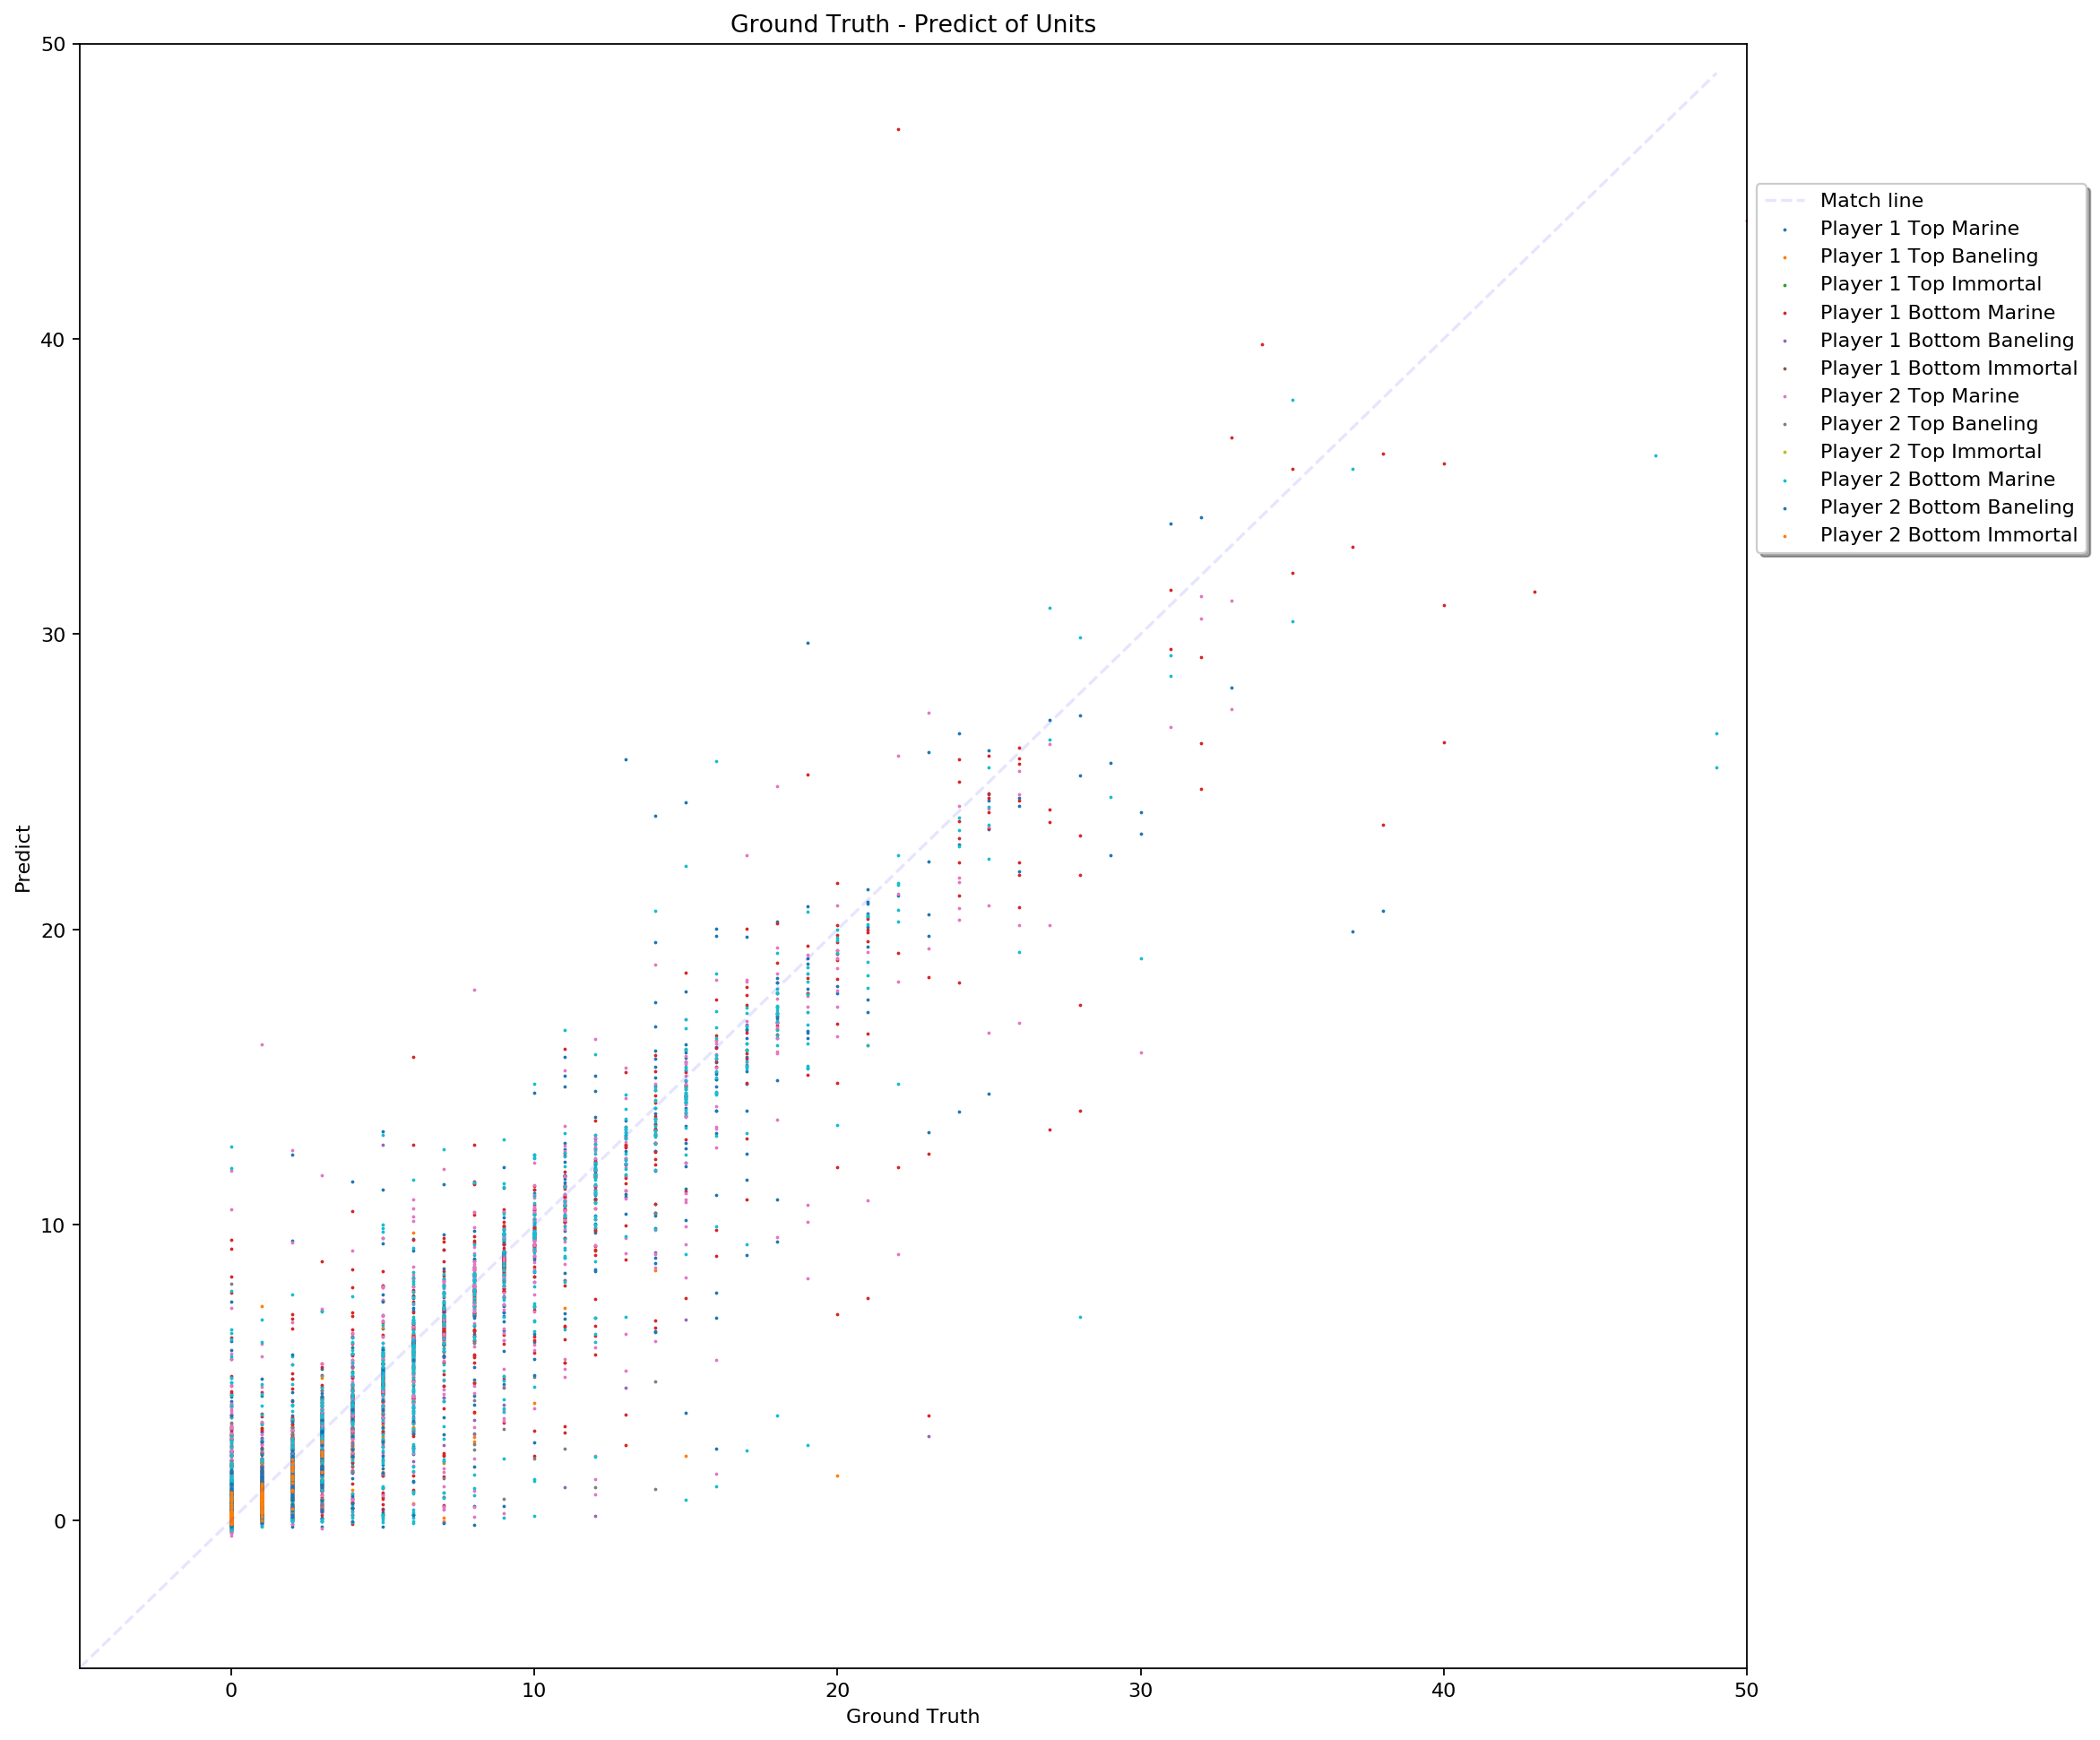

 39%|███▉      | 3925/10000 [05:14<08:34, 11.81it/s]

KeyboardInterrupt: 

In [7]:
state_action = torch.from_numpy(np.stack(train_data[:, 0])).type(FloatTensor)
next_state_reward = torch.from_numpy(np.stack(train_data[:, 1])).type(FloatTensor)
print(state_action.size(), next_state_reward.size())

for epoch in tqdm.tqdm(range(10000)):
    loss = 0
    s = np.arange(state_action.shape[0])
    np.random.shuffle(s)
    train_x = state_action[s]
    train_y = next_state_reward[s]
    for i in range(state_action.shape[0] // batch_size + 1):
        if (i + 1) * batch_size <= state_action.shape[0]:
            start = i * batch_size
            end = (i + 1) * batch_size
        else:
            start = i * batch_size
            end = state_action.shape[0]
        #print(start, end)
        inputs, ground_true = train_x[start : end, :], train_y[start : end, :]
        outputs = trans_model.predict_batch(inputs)
        loss += trans_model.fit(outputs, ground_true)
#     print(epoch)
    summary_test.add_scalars("MSE",{'Train MSE': float(loss / (state_action.shape[0] // batch_size + 1) )}, epoch)
    evaluation(trans_model, test_data, epoch)
    #break

#trans_model.save()

In [8]:
torch.save(trans_model.model.state_dict(), "models_mb/transition_model_unit.pt")

 39%|███▉      | 3925/10000 [05:30<08:34, 11.81it/s]